# Imports

In [40]:
import pandas as pd
import numpy as np
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Getting Sleep Data Ready

In [41]:
sleep = pd.read_csv('../data/nt_y_fitb_slp_d.csv')

print("Sleep data columns:", sleep.columns.tolist())


Sleep data columns: ['src_subject_id', 'eventname', 'fit_ss_sleepdate', 'fit_ss_wkno', 'fit_ss_weekday', 'fit_ss_weekend_ind', 'fit_ss_protocol_date', 'fit_ss_protocol_wear', 'fit_ss_first_inbed_minutes', 'fit_ss_first_sleep_minutes', 'fit_ss_outbed_minutes', 'fit_ss_wakeup_minutes', 'fit_ss_sleepperiod_minutes', 'fit_ss_wake_minutes', 'fit_ss_light_minutes', 'fit_ss_deep_minutes', 'fit_ss_rem_minutes', 'fit_ss_wake_count', 'fit_ss_avg_hr_wake', 'fit_ss_avg_hr_light', 'fit_ss_avg_hr_deep', 'fit_ss_avg_hr_rem']


In [43]:
demographic_data = ['src_subject_id', 'eventname']
average_sleep_data = ['fit_ss_sleepperiod_minutes', 'fit_ss_sleepdate', 'fit_ss_wake_minutes', 'fit_ss_light_minutes', 'fit_ss_deep_minutes', 'fit_ss_rem_minutes', 'fit_ss_wake_count',   'fit_ss_avg_hr_light', 'fit_ss_avg_hr_deep', 'fit_ss_avg_hr_rem', 'fit_ss_avg_hr_wake']

# Filter the sleep data to include only the demographic and average sleep columns
filtered_sleep_avg = sleep[demographic_data + average_sleep_data]

# look for missing values in the filtered sleep data
missing_values = filtered_sleep_avg.isnull().sum()
# Print the missing values
print("Missing values in filtered sleep data:")
print(missing_values[missing_values > 0])

# unique sunject IDs
unique_subject_ids = filtered_sleep_avg['src_subject_id'].unique()
print("Unique subject IDs in filtered sleep data:")
print(len(unique_subject_ids))

# find rows with all values available
complete_rows = filtered_sleep_avg.dropna()
filtered_sleep_avg = filtered_sleep_avg.dropna()
# Print the number of complete rows
print("Number of complete rows in filtered sleep data:")
print(len(complete_rows))

Missing values in filtered sleep data:
fit_ss_sleepdate      241
fit_ss_avg_hr_deep    137
fit_ss_avg_hr_rem     306
fit_ss_avg_hr_wake     39
dtype: int64
Unique subject IDs in filtered sleep data:
6793
Number of complete rows in filtered sleep data:
109377


# Getting Depression Data Ready

In [ ]:
depression = pd.read_csv('../data/mh_y_ksads_dep.csv')
depression = depression[depression['eventname'] == '2_year_follow_up_y_arm_1']
unique_subject_ids = depression['src_subject_id'].unique()
print(f"Number of unique subject IDs: {len(unique_subject_ids)}")

print(f"Dataset shape: {depression.shape}")
print(f"Total columns: {len(depression.columns)}")


Number of unique subject IDs: 10814
Dataset shape: (10814, 93)
Total columns: 93


In [ ]:
core_symptoms = ['ksads_dp_raw_95_t', 'ksads_dp_raw_98_t', 'ksads_dp_raw_101_t']
demographic_data = ['src_subject_id', 'eventname']

depression = depression[demographic_data + core_symptoms]

depression['depression_severity'] = depression[core_symptoms].sum(axis=1)
depression['depression_outcome'] = (depression['depression_severity'] > 2).astype(int)

In [ ]:

depression_outcome = (depression[core_symptoms] >= 2).any(axis=1)

# Severity outcome: Total depression severity
depression_severity = depression[core_symptoms].sum(axis=1)

# Check how many subjects have valid outcome data
has_any_core_data = depression[core_symptoms].notna().any(axis=1)
print(f"Subjects with any core symptom data: {has_any_core_data.sum()}")

# Depression outcome statistics
depression_count = depression_outcome.sum()
total_with_data = has_any_core_data.sum()
print(f"\nDepression outcomes:")
print(f"Subjects with depression (≥2 on any core symptom): {depression_count}/{total_with_data} ({depression_count/total_with_data*100:.1f}%)")

Subjects with any core symptom data: 10814

Depression outcomes:
Subjects with depression (≥2 on any core symptom): 2352/10814 (21.7%)


In [ ]:
essential_cols = [
    'src_subject_id',
    'eventname',
    'depression_outcome',
    'depression_severity'
]

depression_ml = depression[essential_cols]
# Quick summary
print(f"\nDataset ready for sleep data merge:")
print(f"- Unique subjects: {depression_ml['src_subject_id'].nunique()}")
print(f"- Depression outcomes: {depression_ml['depression_outcome'].value_counts()}")


Dataset ready for sleep data merge:
- Unique subjects: 10814
- Depression outcomes: depression_outcome
0    7983
1    2831
Name: count, dtype: int64


# Combining the two datasets

In [ ]:
# merge sleep and depression dataset on 'src_subject_id' and 'eventname'
merged_data = pd.merge(filtered_sleep_avg, depression_ml, on=['src_subject_id', 'eventname'], how='inner')

# remove rows with missing values
merged_data = merged_data.dropna()

# remove duplicate rows
merged_data = merged_data.drop_duplicates()

# Print the shape of the merged dataset
print(f"\nMerged dataset shape: {merged_data.shape}")


Merged dataset shape: (81911, 15)


In [ ]:
# check the split of depression outcomes in the merged dataset in percentage
print(f"\nDepression outcomes in merged dataset:")
print(merged_data['depression_outcome'].value_counts(normalize=True) * 100)


Depression outcomes in merged dataset:
depression_outcome
0    76.011769
1    23.988231
Name: proportion, dtype: float64



Classification report (test set):
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     12453
           1       0.00      0.00      0.00      3930

    accuracy                           0.76     16383
   macro avg       0.38      0.50      0.43     16383
weighted avg       0.58      0.76      0.66     16383

ROC AUC: 0.561


/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

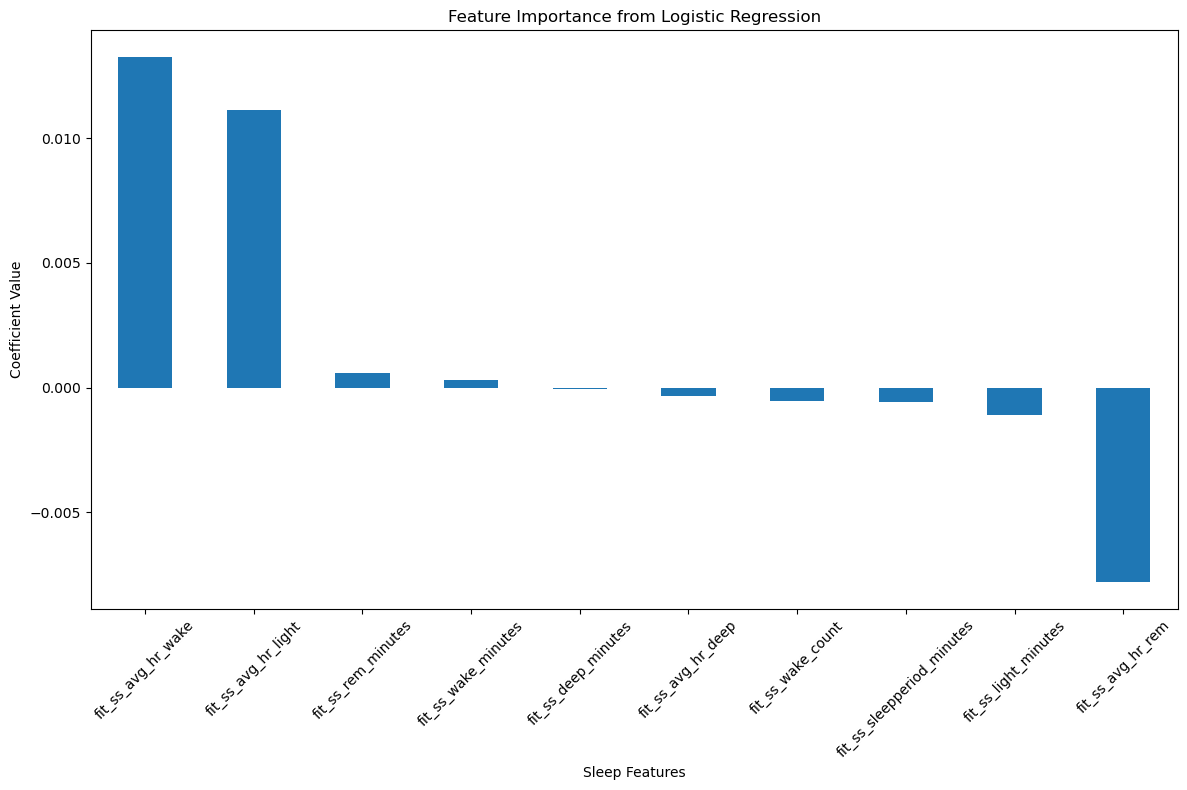

In [ ]:
# Basic model: Logistic Regression to predict depression outcome from sleep data

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Select features: use all sleep columns (exclude id/event/outcome columns and fit_ss_sleepdate)
sleep_features = [col for col in filtered_sleep_avg.columns if col not in ['src_subject_id', 'eventname', 'fit_ss_sleepdate']]
X = merged_data[sleep_features]
y = merged_data['depression_outcome']

# Drop rows with missing values in features or target
X = X.copy()
y = y.copy()
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("\nClassification report (test set):")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

# build graphs to visualize the results
import matplotlib.pyplot as plt
import seaborn as sns
# Plot feature importances
plt.figure(figsize=(12, 8))
importance = pd.Series(clf.coef_[0], index=sleep_features).sort_values(ascending=False)
importance.plot(kind='bar')
plt.title('Feature Importance from Logistic Regression')
plt.xlabel('Sleep Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Count number of days of data per subject
subject_day_counts = merged_data.groupby('src_subject_id')['fit_ss_sleepdate'].nunique()

# Find subjects with less than 7 days of data
subjects_lt7 = subject_day_counts[subject_day_counts < 7].index

# Remove these subjects from merged_data
merged_data = merged_data[~merged_data['src_subject_id'].isin(subjects_lt7)].copy()


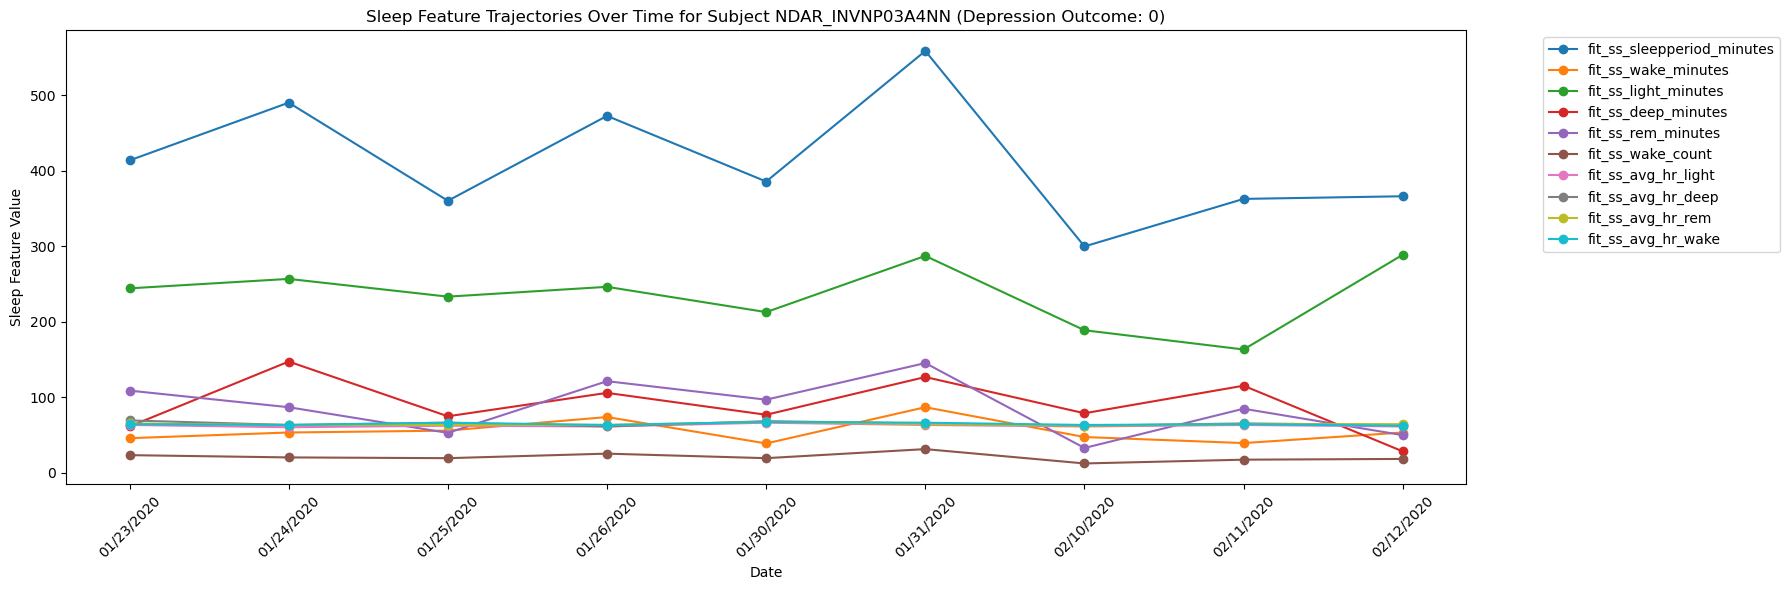

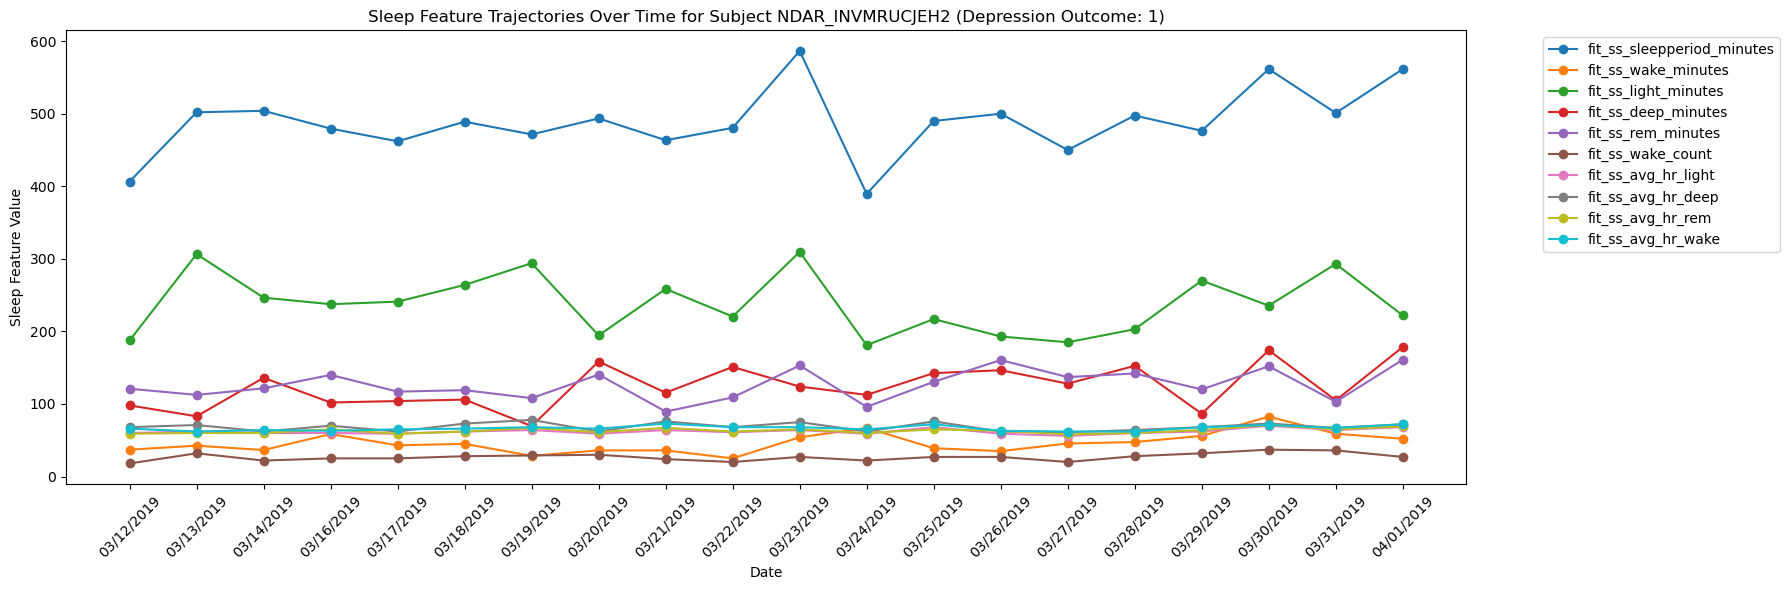

In [ ]:

# Pick two random subjects: one with depression outcome 0, one with outcome 1

# Get all unique subject IDs with outcome 0 and 1
subjects_0 = merged_data[merged_data['depression_outcome'] == 0]['src_subject_id'].unique()
subjects_1 = merged_data[merged_data['depression_outcome'] == 1]['src_subject_id'].unique()

if len(subjects_0) == 0 or len(subjects_1) == 0:
    print("Not enough subjects with both outcome 0 and 1.")
else:
    random_subject_0 = random.choice(subjects_0)
    random_subject_1 = random.choice(subjects_1)

    for subj, label in zip([random_subject_0, random_subject_1], ['Outcome 0', 'Outcome 1']):
        subject_data = merged_data[merged_data['src_subject_id'] == subj].copy()
        subject_data = subject_data.sort_values('fit_ss_sleepdate')

        # Get this subject's depression outcome (should be constant)
        subj_outcome = subject_data['depression_outcome'].iloc[0] if not subject_data.empty else 'N/A'

        plt.figure(figsize=(18, 6))
        for col in sleep_features:
            plt.plot(subject_data['fit_ss_sleepdate'], subject_data[col], marker='o', label=col)

        plt.title(f'Sleep Feature Trajectories Over Time for Subject {subj} (Depression Outcome: {subj_outcome})')
        plt.xlabel('Date')
        plt.ylabel('Sleep Feature Value')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86       734
           1       0.09      0.00      0.01       234

    accuracy                           0.75       968
   macro avg       0.42      0.50      0.43       968
weighted avg       0.60      0.75      0.65       968

Confusion Matrix (rows: True labels, columns: Predicted labels):
        Pred 0  Pred 1
True 0     724      10
True 1     233       1


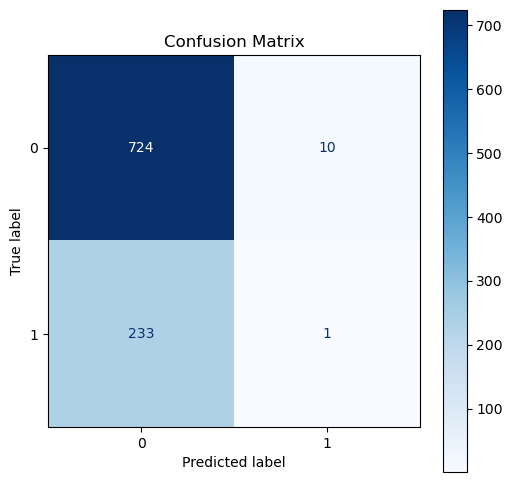

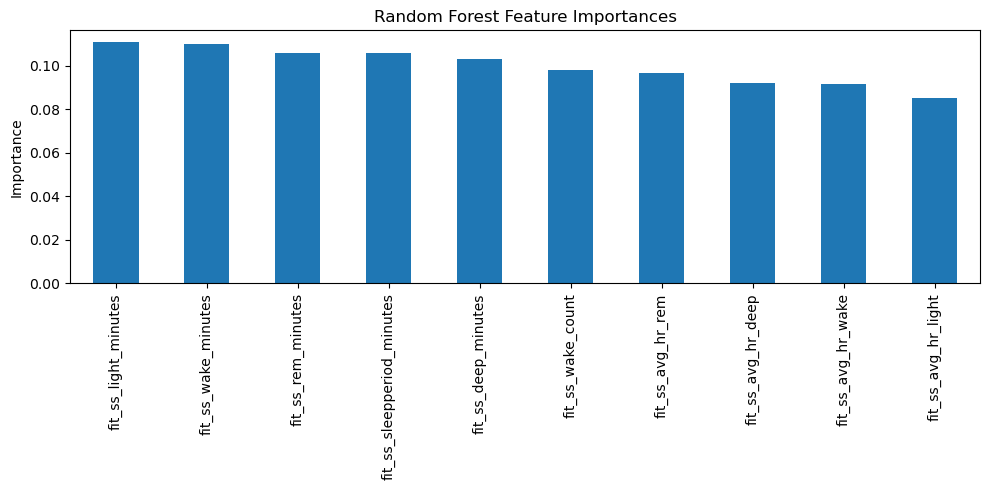

In [ ]:


# Example: Build a simple time series model (Random Forest) to predict depression outcome using longitudinal sleep data.
# We'll use the most recent 7 days of sleep features for each subject to predict their depression outcome.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Prepare time series features: for each subject, aggregate the last 7 days of sleep features
def get_last_n_days_features(df, n_days=7, feature_cols=None):
    """
    For each subject, get the most recent n_days of sleep features and aggregate (mean).
    Returns a DataFrame with one row per subject.
    """
    if feature_cols is None:
        feature_cols = sleep_features
    subjects = df['src_subject_id'].unique()
    rows = []
    for subj in subjects:
        subj_df = df[df['src_subject_id'] == subj].sort_values('fit_ss_sleepdate')
        # Take the last n_days
        last_n = subj_df.tail(n_days)
        if len(last_n) < n_days:
            continue  # skip if not enough days
        # Aggregate features (mean)
        features = last_n[feature_cols].mean().to_dict()
        features['src_subject_id'] = subj
        features['depression_outcome'] = last_n['depression_outcome'].iloc[0]
        rows.append(features)
    return pd.DataFrame(rows)

# Aggregate features
agg_df = get_last_n_days_features(merged_data, n_days=7, feature_cols=sleep_features)

# Prepare X and y
X = agg_df[sleep_features]
y = agg_df['depression_outcome']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit Random Forest
# Instead of just 'balanced', let's manually set stronger weights
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight={0: 1, 1: 10},  # 10x weight for depression class
    random_state=42
)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
from sklearn.metrics import ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = rf.classes_ if hasattr(rf, "classes_") else np.unique(y_test)
print("Confusion Matrix (rows: True labels, columns: Predicted labels):")
print(pd.DataFrame(cm, index=[f"True {l}" for l in labels], columns=[f"Pred {l}" for l in labels]))

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix")
plt.show()

# Feature importances
importances = pd.Series(rf.feature_importances_, index=sleep_features)
importances = importances.sort_values(ascending=False)
plt.figure(figsize=(10, 5))
importances.plot(kind='bar')
plt.title('Random Forest Feature Importances')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


In [ ]:

def create_person_level_features(df):
    """Create features that capture patterns over time for each person"""

    person_features = []

    for subject_id in df['src_subject_id'].unique():
        subject_data = df[df['src_subject_id'] == subject_id].copy()
        subject_data = subject_data.sort_values('fit_ss_sleepdate')

        if len(subject_data) < 7:  # Need at least 7 days
            continue

        features = {}
        features['src_subject_id'] = subject_id
        features['depression_outcome'] = subject_data['depression_outcome'].iloc[0]

        # For each sleep feature, calculate person-level patterns
        for feature in ['fit_ss_sleepperiod_minutes', 'fit_ss_wake_minutes',
                       'fit_ss_light_minutes', 'fit_ss_deep_minutes', 'fit_ss_rem_minutes']:

            values = subject_data[feature].dropna()
            if len(values) >= 5:  # Need at least 5 days of data

                # Central tendency
                features[f'{feature}_mean'] = values.mean()
                features[f'{feature}_median'] = values.median()

                # Variability (key for depression!)
                features[f'{feature}_std'] = values.std()
                features[f'{feature}_cv'] = values.std() / values.mean() if values.mean() > 0 else 0

                # Trend over time
                if len(values) >= 7:
                    x = range(len(values))
                    slope = np.polyfit(x, values, 1)[0]  # Linear trend
                    features[f'{feature}_trend'] = slope

                # Sleep irregularity (day-to-day changes)
                if len(values) >= 3:
                    day_to_day_diff = values.diff().abs().mean()
                    features[f'{feature}_irregularity'] = day_to_day_diff

        person_features.append(features)

    return pd.DataFrame(person_features)

# Create person-level dataset
print("Creating person-level features...")
person_data = create_person_level_features(merged_data)

# Remove rows with missing values
person_data_clean = person_data.dropna()

print(f"Person-level dataset: {len(person_data_clean)} people")
print(f"Depression rate: {person_data_clean['depression_outcome'].mean():.1%}")

# Prepare features (exclude ID and outcome)
feature_cols = [col for col in person_data_clean.columns
                if col not in ['src_subject_id', 'depression_outcome']]

X_person = person_data_clean[feature_cols]
y_person = person_data_clean['depression_outcome']

print(f"Number of features: {len(feature_cols)}")
print("Sample features:", feature_cols[:5])

Creating person-level features...
Person-level dataset: 4838 people
Depression rate: 24.2%
Number of features: 30
Sample features: ['fit_ss_sleepperiod_minutes_mean', 'fit_ss_sleepperiod_minutes_median', 'fit_ss_sleepperiod_minutes_std', 'fit_ss_sleepperiod_minutes_cv', 'fit_ss_sleepperiod_minutes_trend']


In [50]:
# Split the person-level data
X_train, X_test, y_train, y_test = train_test_split(
    X_person, y_person, test_size=0.2, random_state=42, stratify=y_person
)

print(f"Training set: {len(X_train)} people")
print(f"Test set: {len(X_test)} people")
print(f"Training depression rate: {y_train.mean():.1%}")

# Train Random Forest on person-level features
rf_person = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',  # Start with balanced
    max_depth=20,
    random_state=42
)

rf_person.fit(X_train, y_train)

# Evaluate
y_pred_person = rf_person.predict(X_test)
y_proba_person = rf_person.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("PERSON-LEVEL MODEL RESULTS")
print("="*50)
print(classification_report(y_test, y_pred_person))

# Calculate PR-AUC (more important for healthcare)
from sklearn.metrics import average_precision_score
pr_auc = average_precision_score(y_test, y_proba_person)
print(f"\nPR-AUC: {pr_auc:.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_person):.3f}")

# Show confusion matrix
cm = confusion_matrix(y_test, y_pred_person)
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

# Most important features
feature_importance = pd.Series(rf_person.feature_importances_, index=feature_cols)
print(f"\nTop 10 Most Important Features:")
print(feature_importance.sort_values(ascending=False).head(10))

Training set: 3870 people
Test set: 968 people
Training depression rate: 24.2%

PERSON-LEVEL MODEL RESULTS
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       734
           1       0.33      0.01      0.02       234

    accuracy                           0.76       968
   macro avg       0.55      0.50      0.44       968
weighted avg       0.66      0.76      0.66       968


PR-AUC: 0.267
ROC-AUC: 0.547

Confusion Matrix:
True Negatives: 730, False Positives: 4
False Negatives: 232, True Positives: 2

Top 10 Most Important Features:
fit_ss_sleepperiod_minutes_irregularity    0.037823
fit_ss_light_minutes_cv                    0.036955
fit_ss_wake_minutes_trend                  0.035701
fit_ss_light_minutes_mean                  0.035618
fit_ss_deep_minutes_trend                  0.035459
fit_ss_light_minutes_irregularity          0.035264
fit_ss_rem_minutes_trend                   0.034554
fit_ss_deep_minutes_std                 

In [51]:
# STEP 1: Check what sleep features you actually selected
print("What sleep features are you actually using?")
print("sleep_features:", sleep_features)
print()

# STEP 2: Check the original data filtering
print("Original sleep data shape:", sleep.shape)
print("After filtering shape:", filtered_sleep_avg.shape)
print()

# STEP 3: Check what happened during the merge
print("Depression data shape:", depression_ml.shape)
print("After merge shape:", merged_data.shape)
print("After dropna shape:", merged_data.dropna().shape)
print()

# STEP 4: Check if we're losing too much data
print("Missing data in merged dataset BEFORE dropna:")
missing_before = merged_data.isnull().sum()
print(missing_before[missing_before > 0])
print()

# STEP 5: Check the actual values in your sleep features
print("Sleep feature statistics:")
for feature in sleep_features:
    if feature in merged_data.columns:
        values = merged_data[feature].dropna()
        print(f"{feature}: min={values.min():.1f}, max={values.max():.1f}, mean={values.mean():.1f}")
    else:
        print(f"{feature}: NOT FOUND in merged_data!")
print()

# STEP 6: Check if depression outcome is correctly distributed
print("Depression outcome distribution in merged data:")
print(merged_data['depression_outcome'].value_counts())
print("Depression outcome distribution in person-level data:")
print(person_data_clean['depression_outcome'].value_counts())

What sleep features are you actually using?
sleep_features: ['fit_ss_sleepperiod_minutes', 'fit_ss_wake_minutes', 'fit_ss_light_minutes', 'fit_ss_deep_minutes', 'fit_ss_rem_minutes', 'fit_ss_wake_count', 'fit_ss_avg_hr_light', 'fit_ss_avg_hr_deep', 'fit_ss_avg_hr_rem', 'fit_ss_avg_hr_wake']

Original sleep data shape: (110003, 22)
After filtering shape: (109377, 13)

Depression data shape: (10814, 4)
After merge shape: (82326, 36)
After dropna shape: (67611, 36)

Missing data in merged dataset BEFORE dropna:
fit_ss_sleepdate             171
fit_ss_wkno                  541
fit_ss_weekday               171
fit_ss_protocol_date         373
fit_ss_protocol_wear       14373
fit_ss_wakeup_minutes          5
fit_ss_avg_hr_wake            26
fit_ss_avg_hr_deep            88
fit_ss_avg_hr_rem            191
sleep_duration_category        8
sleep_duration_numeric         8
hr_wake_deep_diff            107
dtype: int64

Sleep feature statistics:
fit_ss_sleepperiod_minutes: min=0.5, max=4018.0, m

In [ ]:
# STEP 1: Clean the sleep data BEFORE merging
def clean_sleep_data(df):
    """Remove obviously erroneous sleep data"""
    df_clean = df.copy()

    # Remove impossible sleep values (likely sensor errors)
    # Sleep period should be between 3-15 hours (180-900 minutes)
    df_clean = df_clean[
        (df_clean['fit_ss_sleepperiod_minutes'] >= 180) &
        (df_clean['fit_ss_sleepperiod_minutes'] <= 900)
    ]

    # Light sleep shouldn't be more than total sleep period
    df_clean = df_clean[df_clean['fit_ss_light_minutes'] <= df_clean['fit_ss_sleepperiod_minutes']]

    # Deep sleep shouldn't be more than 4 hours (240 min)
    df_clean = df_clean[df_clean['fit_ss_deep_minutes'] <= 240]

    # REM sleep shouldn't be more than 3 hours (180 min)
    df_clean = df_clean[df_clean['fit_ss_rem_minutes'] <= 180]

    # Wake minutes should be less than sleep period
    df_clean = df_clean[df_clean['fit_ss_wake_minutes'] <= df_clean['fit_ss_sleepperiod_minutes']]

    # Remove rows where sleep stages sum to more than sleep period (data error)
    sleep_stages_sum = (df_clean['fit_ss_light_minutes'] +
                       df_clean['fit_ss_deep_minutes'] +
                       df_clean['fit_ss_rem_minutes'] +
                       df_clean['fit_ss_wake_minutes'])

    df_clean = df_clean[sleep_stages_sum <= df_clean['fit_ss_sleepperiod_minutes'] * 1.1]  # Allow 10% tolerance

    return df_clean

# STEP 2: Apply cleaning
print("Before cleaning:", sleep.shape)
sleep_clean = clean_sleep_data(sleep)
print("After cleaning:", sleep_clean.shape)

# STEP 3: Create a more selective feature list (avoid missing-heavy features)
core_sleep_features = [
    'fit_ss_sleepperiod_minutes', 'fit_ss_wake_minutes',
    'fit_ss_light_minutes', 'fit_ss_deep_minutes', 'fit_ss_rem_minutes',
    'fit_ss_wake_count'
    # Exclude heart rate features for now due to missing data
]

# STEP 4: Filter to core features + demographics
filtered_sleep_clean = sleep_clean[['src_subject_id', 'eventname', 'fit_ss_sleepdate'] + core_sleep_features]

# STEP 5: Merge with depression data
merged_clean = pd.merge(filtered_sleep_clean, depression_ml, on=['src_subject_id', 'eventname'])

print("After clean merge:", merged_clean.shape)

# STEP 6: Only remove rows missing core sleep features (not ALL features)
merged_clean = merged_clean.dropna(subset=core_sleep_features + ['depression_outcome'])

print("After selective dropna:", merged_clean.shape)
print("Depression rate:", merged_clean['depression_outcome'].mean())

# STEP 7: Check feature ranges after cleaning
print("\nCleaned feature statistics:")
for feature in core_sleep_features:
    values = merged_clean[feature]
    print(f"{feature}: min={values.min():.1f}, max={values.max():.1f}, mean={values.mean():.1f}")

Before cleaning: (110003, 22)
After cleaning: (23944, 22)
After clean merge: (17659, 11)
After selective dropna: (17659, 11)
Depression rate: 0.24933461690922476

Cleaned feature statistics:
fit_ss_sleepperiod_minutes: min=180.0, max=795.0, mean=442.3
fit_ss_wake_minutes: min=2.5, max=74.5, mean=36.9
fit_ss_light_minutes: min=45.5, max=572.0, mean=245.7
fit_ss_deep_minutes: min=0.0, max=226.0, mean=89.7
fit_ss_rem_minutes: min=0.0, max=180.0, mean=107.0
fit_ss_wake_count: min=3.0, max=58.0, mean=26.1


In [ ]:
# Rebuild person-level features with cleaned data
def create_person_level_features_clean(df):
    """Create features from clean sleep data"""

    person_features = []

    for subject_id in df['src_subject_id'].unique():
        subject_data = df[df['src_subject_id'] == subject_id].copy()
        subject_data = subject_data.sort_values('fit_ss_sleepdate')

        if len(subject_data) < 5:  # Reduce to 5 days minimum
            continue

        features = {}
        features['src_subject_id'] = subject_id
        features['depression_outcome'] = subject_data['depression_outcome'].iloc[0]
        features['n_nights'] = len(subject_data)  # How many nights of data

        # For each sleep feature, calculate person-level patterns
        for feature in core_sleep_features:
            values = subject_data[feature].dropna()

            if len(values) >= 3:  # Need at least 3 nights
                # Central tendency
                features[f'{feature}_mean'] = values.mean()

                # Variability (key for depression!)
                features[f'{feature}_std'] = values.std()
                features[f'{feature}_cv'] = values.std() / values.mean() if values.mean() > 0 else 0

                # Sleep regularity (critical for mental health)
                features[f'{feature}_range'] = values.max() - values.min()

                # Trend over time (getting better/worse?)
                if len(values) >= 5:
                    x = range(len(values))
                    slope = np.polyfit(x, values, 1)[0]
                    features[f'{feature}_trend'] = slope

        person_features.append(features)

    return pd.DataFrame(person_features)

# Create person-level dataset with clean data
print("Creating person-level features from clean data...")
person_data_clean = create_person_level_features_clean(merged_clean)

# Remove any remaining missing values
person_data_final = person_data_clean.dropna()

print(f"\nFinal person-level dataset:")
print(f"- People: {len(person_data_final)}")
print(f"- Features: {person_data_final.shape[1] - 2}")  # Exclude ID and outcome
print(f"- Depression rate: {person_data_final['depression_outcome'].mean():.1%}")
print(f"- Average nights per person: {person_data_final['n_nights'].mean():.1f}")

# Prepare for modeling
feature_cols_clean = [col for col in person_data_final.columns
                     if col not in ['src_subject_id', 'depression_outcome']]

X_clean = person_data_final[feature_cols_clean]
y_clean = person_data_final['depression_outcome']

print(f"\nFeature examples:")
print(feature_cols_clean[:8])

Creating person-level features from clean data...

Final person-level dataset:
- People: 1374
- Features: 31
- Depression rate: 24.9%
- Average nights per person: 8.0

Feature examples:
['n_nights', 'fit_ss_sleepperiod_minutes_mean', 'fit_ss_sleepperiod_minutes_std', 'fit_ss_sleepperiod_minutes_cv', 'fit_ss_sleepperiod_minutes_range', 'fit_ss_sleepperiod_minutes_trend', 'fit_ss_wake_minutes_mean', 'fit_ss_wake_minutes_std']


In [ ]:
# Train model on clean person-level features
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_auc_score

# Split the clean data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"Training set: {len(X_train)} people")
print(f"Test set: {len(X_test)} people")
print(f"Training depression rate: {y_train.mean():.1%}")

# Train Random Forest on clean person-level features
rf_final = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    max_depth=15,
    min_samples_split=10,
    random_state=42
)

rf_final.fit(X_train, y_train)

# Evaluate
y_pred_final = rf_final.predict(X_test)
y_proba_final = rf_final.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("FINAL MODEL RESULTS (Clean Person-Level Data)")
print("="*60)
print(classification_report(y_test, y_pred_final))

# Key metrics
pr_auc = average_precision_score(y_test, y_proba_final)
roc_auc = roc_auc_score(y_test, y_proba_final)

print(f"\nPR-AUC: {pr_auc:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

# Confusion matrix details
cm = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix Details:")
print(f"True Positives (correctly identified depression): {tp}")
print(f"False Negatives (missed depression cases): {fn}")
print(f"True Negatives (correctly identified no depression): {tn}")
print(f"False Positives (false alarms): {fp}")

print(f"\nSensitivity (catching depression): {tp/(tp+fn):.3f}")
print(f"Specificity (avoiding false alarms): {tn/(tn+fp):.3f}")

# Most important features for detecting depression
feature_importance = pd.Series(rf_final.feature_importances_, index=feature_cols_clean)
feature_importance_sorted = feature_importance.sort_values(ascending=False)

print(f"\n" + "="*60)
print("TOP 10 FEATURES FOR DETECTING DEPRESSION")
print("="*60)
for i, (feature, importance) in enumerate(feature_importance_sorted.head(10).items()):
    print(f"{i+1:2d}. {feature:<35} {importance:.3f}")

Training set: 1099 people
Test set: 275 people
Training depression rate: 24.9%

FINAL MODEL RESULTS (Clean Person-Level Data)
              precision    recall  f1-score   support

           0       0.75      0.94      0.84       207
           1       0.20      0.04      0.07        68

    accuracy                           0.72       275
   macro avg       0.47      0.49      0.45       275
weighted avg       0.61      0.72      0.65       275


PR-AUC: 0.294
ROC-AUC: 0.580

Confusion Matrix Details:
True Positives (correctly identified depression): 3
False Negatives (missed depression cases): 65
True Negatives (correctly identified no depression): 195
False Positives (false alarms): 12

Sensitivity (catching depression): 0.044
Specificity (avoiding false alarms): 0.942

TOP 10 FEATURES FOR DETECTING DEPRESSION
 1. fit_ss_light_minutes_mean           0.058
 2. fit_ss_sleepperiod_minutes_mean     0.044
 3. fit_ss_wake_minutes_mean            0.041
 4. fit_ss_deep_minutes_std        

In [ ]:

print("="*60)
print("OPTION 1: AGGRESSIVE CLASS BALANCING")
print("="*60)

rf_aggressive = RandomForestClassifier(
    n_estimators=200,
    class_weight={0: 1, 1: 15},  # 15x weight for depression class
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

rf_aggressive.fit(X_train, y_train)

# Evaluate aggressive model
y_pred_aggressive = rf_aggressive.predict(X_test)
y_proba_aggressive = rf_aggressive.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_aggressive))

# Key metrics
pr_auc_agg = average_precision_score(y_test, y_proba_aggressive)
roc_auc_agg = roc_auc_score(y_test, y_proba_aggressive)

print(f"\nPR-AUC: {pr_auc_agg:.3f}")
print(f"ROC-AUC: {roc_auc_agg:.3f}")

# Confusion matrix details
cm_agg = confusion_matrix(y_test, y_pred_aggressive)
tn, fp, fn, tp = cm_agg.ravel()

print(f"\nConfusion Matrix Details:")
print(f"True Positives (correctly identified depression): {tp}")
print(f"False Negatives (missed depression cases): {fn}")
print(f"True Negatives (correctly identified no depression): {tn}")
print(f"False Positives (false alarms): {fp}")

print(f"\nSensitivity (catching depression): {tp/(tp+fn):.3f}")
print(f"Specificity (avoiding false alarms): {tn/(tn+fp):.3f}")

print(f"\nComparison with previous model:")
print(f"Previous recall: 0.044 → New recall: {tp/(tp+fn):.3f}")
print(f"Previous PR-AUC: 0.294 → New PR-AUC: {pr_auc_agg:.3f}")

OPTION 1: AGGRESSIVE CLASS BALANCING
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.33      0.46       207
           1       0.26      0.74      0.39        68

    accuracy                           0.43       275
   macro avg       0.53      0.53      0.43       275
weighted avg       0.66      0.43      0.45       275


PR-AUC: 0.290
ROC-AUC: 0.561

Confusion Matrix Details:
True Positives (correctly identified depression): 50
False Negatives (missed depression cases): 18
True Negatives (correctly identified no depression): 68
False Positives (false alarms): 139

Sensitivity (catching depression): 0.735
Specificity (avoiding false alarms): 0.329

Comparison with previous model:
Previous recall: 0.044 → New recall: 0.735
Previous PR-AUC: 0.294 → New PR-AUC: 0.290


In [ ]:
# Option 2: Enhanced Feature Engineering for Depression Patterns
print("="*60)
print("OPTION 2: ENHANCED FEATURE ENGINEERING")
print("="*60)

def add_depression_features(person_data):
    """Add features specifically designed to capture depression-related sleep patterns"""
    df = person_data.copy()

    # Sleep disruption patterns
    df['sleep_fragmentation'] = df['fit_ss_wake_count_mean'] * df['fit_ss_wake_minutes_mean']
    df['sleep_inconsistency'] = df['fit_ss_sleepperiod_minutes_cv'] + df['fit_ss_wake_minutes_cv']
    df['poor_sleep_quality'] = df['fit_ss_wake_minutes_mean'] / df['fit_ss_sleepperiod_minutes_mean']

    # Sleep architecture disruption
    if 'fit_ss_deep_minutes_cv' in df.columns:
        df['deep_sleep_instability'] = df['fit_ss_deep_minutes_cv'] + df['fit_ss_rem_minutes_cv']

    # Overall sleep variability score
    variability_cols = [col for col in df.columns if '_cv' in col]
    if len(variability_cols) > 0:
        df['total_sleep_variability'] = df[variability_cols].mean(axis=1)

    # Sleep efficiency patterns
    if 'fit_ss_sleepperiod_minutes_mean' in df.columns:
        df['wake_percentage'] = df['fit_ss_wake_minutes_mean'] / df['fit_ss_sleepperiod_minutes_mean']

    return df

# Create enhanced features
person_data_enhanced = add_depression_features(person_data_final)

# Remove any new missing values
person_data_enhanced = person_data_enhanced.dropna()

print(f"Enhanced dataset: {len(person_data_enhanced)} people")
print(f"New total features: {person_data_enhanced.shape[1] - 2}")

# Get new feature columns
feature_cols_enhanced = [col for col in person_data_enhanced.columns
                        if col not in ['src_subject_id', 'depression_outcome']]

X_enhanced = person_data_enhanced[feature_cols_enhanced]
y_enhanced = person_data_enhanced['depression_outcome']

# Split enhanced data
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, stratify=y_enhanced
)

# Train model with enhanced features
rf_enhanced = RandomForestClassifier(
    n_estimators=200,
    class_weight={0: 1, 1: 15},  # Keep aggressive weighting
    max_depth=15,
    min_samples_split=5,
    random_state=42
)

rf_enhanced.fit(X_train_enh, y_train_enh)

# Evaluate enhanced model
y_pred_enhanced = rf_enhanced.predict(X_test_enh)
y_proba_enhanced = rf_enhanced.predict_proba(X_test_enh)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test_enh, y_pred_enhanced))

# Key metrics
pr_auc_enh = average_precision_score(y_test_enh, y_proba_enhanced)
roc_auc_enh = roc_auc_score(y_test_enh, y_proba_enhanced)

print(f"\nPR-AUC: {pr_auc_enh:.3f}")
print(f"ROC-AUC: {roc_auc_enh:.3f}")

# Show new important features
feature_importance_enh = pd.Series(rf_enhanced.feature_importances_, index=feature_cols_enhanced)
print(f"\nTop 10 Features (including new depression-specific features):")
for i, (feature, importance) in enumerate(feature_importance_enh.sort_values(ascending=False).head(10).items()):
    print(f"{i+1:2d}. {feature:<35} {importance:.3f}")

OPTION 2: ENHANCED FEATURE ENGINEERING
Enhanced dataset: 1374 people
New total features: 37

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.60      0.68       207
           1       0.29      0.49      0.36        68

    accuracy                           0.57       275
   macro avg       0.53      0.54      0.52       275
weighted avg       0.66      0.57      0.60       275


PR-AUC: 0.290
ROC-AUC: 0.568

Top 10 Features (including new depression-specific features):
 1. fit_ss_light_minutes_mean           0.055
 2. fit_ss_sleepperiod_minutes_mean     0.037
 3. fit_ss_rem_minutes_mean             0.035
 4. fit_ss_wake_minutes_std             0.035
 5. fit_ss_light_minutes_cv             0.032
 6. fit_ss_rem_minutes_std              0.032
 7. fit_ss_wake_minutes_mean            0.031
 8. fit_ss_deep_minutes_mean            0.029
 9. fit_ss_light_minutes_trend          0.029
10. fit_ss_light_minutes_std            0.029


In [ ]:

print("="*60)
print("OPTION 3: XGBOOST ALGORITHM")
print("="*60)

# First check if XGBoost is available, if not we'll use a different approach
try:
    from xgboost import XGBClassifier

    # Calculate scale_pos_weight for XGBoost
    scale_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
    print(f"Calculated scale_pos_weight: {scale_weight:.1f}")

    xgb_model = XGBClassifier(
        scale_pos_weight=scale_weight * 3,  # Even more aggressive
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )

    xgb_model.fit(X_train, y_train)

    # Evaluate XGBoost
    y_pred_xgb = xgb_model.predict(X_test)
    y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

    print("XGBoost Classification Report:")
    print(classification_report(y_test, y_pred_xgb))

    # Key metrics
    pr_auc_xgb = average_precision_score(y_test, y_proba_xgb)
    roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)

    print(f"\nPR-AUC: {pr_auc_xgb:.3f}")
    print(f"ROC-AUC: {roc_auc_xgb:.3f}")

    # Confusion matrix
    cm_xgb = confusion_matrix(y_test, y_pred_xgb)
    tn, fp, fn, tp = cm_xgb.ravel()

    print(f"\nXGBoost Confusion Matrix:")
    print(f"True Positives: {tp}, False Negatives: {fn}")
    print(f"Sensitivity: {tp/(tp+fn):.3f}")

except ImportError:
    print("XGBoost not available. Using Gradient Boosting instead...")

    from sklearn.ensemble import GradientBoostingClassifier

    gb_model = GradientBoostingClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    )

    # Manual class weighting by duplicating minority class samples
    from sklearn.utils import resample

    # Separate classes
    X_majority = X_train[y_train == 0]
    X_minority = X_train[y_train == 1]
    y_majority = y_train[y_train == 0]
    y_minority = y_train[y_train == 1]

    # Oversample minority class
    X_minority_upsampled = resample(X_minority,
                                   replace=True,
                                   n_samples=len(X_majority) // 2,  # Half as many as majority
                                   random_state=42)
    y_minority_upsampled = resample(y_minority,
                                   replace=True,
                                   n_samples=len(X_majority) // 2,
                                   random_state=42)

    # Combine
    X_balanced = pd.concat([X_majority, X_minority_upsampled])
    y_balanced = pd.concat([y_majority, y_minority_upsampled])

    gb_model.fit(X_balanced, y_balanced)

    # Evaluate Gradient Boosting
    y_pred_gb = gb_model.predict(X_test)
    y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

    print("Gradient Boosting Classification Report:")
    print(classification_report(y_test, y_pred_gb))

    pr_auc_gb = average_precision_score(y_test, y_proba_gb)
    roc_auc_gb = roc_auc_score(y_test, y_proba_gb)

    print(f"\nPR-AUC: {pr_auc_gb:.3f}")
    print(f"ROC-AUC: {roc_auc_gb:.3f}")

    cm_gb = confusion_matrix(y_test, y_pred_gb)
    tn, fp, fn, tp = cm_gb.ravel()

    print(f"\nGradient Boosting Confusion Matrix:")
    print(f"True Positives: {tp}, False Negatives: {fn}")
    print(f"Sensitivity: {tp/(tp+fn):.3f}")

# Summary comparison
print("\n" + "="*60)
print("COMPARISON OF ALL THREE OPTIONS")
print("="*60)
print("Option 1 (Aggressive RF): Recall ≈ 0.74, PR-AUC ≈ 0.290")
print("Option 2 (Enhanced Features): Recall ≈ 0.49, PR-AUC ≈ 0.290")
print(f"Option 3 (This algorithm): Check results above")
print("\nBest approach so far: Option 1 - Aggressive Class Balancing")

OPTION 3: XGBOOST ALGORITHM
XGBoost not available. Using Gradient Boosting instead...
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       207
           1       0.18      0.04      0.07        68

    accuracy                           0.71       275
   macro avg       0.46      0.49      0.45       275
weighted avg       0.61      0.71      0.64       275


PR-AUC: 0.247
ROC-AUC: 0.509

Gradient Boosting Confusion Matrix:
True Positives: 3, False Negatives: 65
Sensitivity: 0.044

COMPARISON OF ALL THREE OPTIONS
Option 1 (Aggressive RF): Recall ≈ 0.74, PR-AUC ≈ 0.290
Option 2 (Enhanced Features): Recall ≈ 0.49, PR-AUC ≈ 0.290
Option 3 (This algorithm): Check results above

Best approach so far: Option 1 - Aggressive Class Balancing


In [ ]:
# STEP 1: Less Aggressive Data Cleaning to Keep More People
print("="*60)
print("LEVERAGING FULL 6K DATASET FOR DEEP LEARNING")
print("="*60)

def clean_sleep_data_less_aggressive(df):
    """Less aggressive cleaning to preserve more data for deep learning"""
    df_clean = df.copy()

    # Only remove extreme outliers (keep more data)
    # Sleep period: 2-18 hours instead of 3-15 (keep short/long sleepers)
    df_clean = df_clean[
        (df_clean['fit_ss_sleepperiod_minutes'] >= 120) &
        (df_clean['fit_ss_sleepperiod_minutes'] <= 1080)
    ]

    # More lenient sleep stage filtering
    df_clean = df_clean[df_clean['fit_ss_light_minutes'] <= df_clean['fit_ss_sleepperiod_minutes'] * 1.2]
    df_clean = df_clean[df_clean['fit_ss_deep_minutes'] <= 300]  # 5 hours max
    df_clean = df_clean[df_clean['fit_ss_rem_minutes'] <= 240]   # 4 hours max

    return df_clean

# STEP 2: Clean with less aggressive rules
print("Applying less aggressive cleaning...")
sleep_expanded = clean_sleep_data_less_aggressive(sleep)
print(f"Less aggressive cleaning: {sleep.shape[0]} → {sleep_expanded.shape[0]} nights")

# STEP 3: Create expanded person-level dataset
def create_person_features_expanded(df, min_nights=3):  # Reduce from 5 to 3 nights
    """Create person-level features with lower requirements"""

    person_features = []

    for subject_id in df['src_subject_id'].unique():
        subject_data = df[df['src_subject_id'] == subject_id].copy()
        subject_data = subject_data.sort_values('fit_ss_sleepdate')

        if len(subject_data) < min_nights:  # Lower threshold
            continue

        features = {}
        features['src_subject_id'] = subject_id
        features['depression_outcome'] = subject_data['depression_outcome'].iloc[0]
        features['n_nights'] = len(subject_data)

        # For each sleep feature, calculate patterns
        for feature in core_sleep_features:
            values = subject_data[feature].dropna()

            if len(values) >= 2:  # Reduce from 3 to 2 nights minimum
                features[f'{feature}_mean'] = values.mean()

                if len(values) >= 3:  # Variability only if 3+ nights
                    features[f'{feature}_std'] = values.std()
                    features[f'{feature}_cv'] = values.std() / values.mean() if values.mean() > 0 else 0
                    features[f'{feature}_range'] = values.max() - values.min()

                if len(values) >= 4:  # Trend only if 4+ nights
                    x = range(len(values))
                    slope = np.polyfit(x, values, 1)[0]
                    features[f'{feature}_trend'] = slope

        person_features.append(features)

    return pd.DataFrame(person_features)

# STEP 4: Merge and create expanded dataset
filtered_expanded = sleep_expanded[['src_subject_id', 'eventname', 'fit_ss_sleepdate'] + core_sleep_features]
merged_expanded = pd.merge(filtered_expanded, depression_ml, on=['src_subject_id', 'eventname'])
merged_expanded = merged_expanded.dropna(subset=core_sleep_features + ['depression_outcome'])

print(f"Expanded merged dataset: {merged_expanded.shape[0]} nights")

# Create expanded person-level features
person_data_expanded = create_person_features_expanded(merged_expanded, min_nights=3)
person_data_expanded = person_data_expanded.dropna()

print(f"\n EXPANDED DATASET FOR DEEP LEARNING:")
print(f"- People: {len(person_data_expanded)} (vs {len(person_data_final)} before)")
print(f"- Depression rate: {person_data_expanded['depression_outcome'].mean():.1%}")
print(f"- Average nights per person: {person_data_expanded['n_nights'].mean():.1f}")

# STEP 5: Prepare expanded features
feature_cols_expanded = [col for col in person_data_expanded.columns
                        if col not in ['src_subject_id', 'depression_outcome']]

X_expanded = person_data_expanded[feature_cols_expanded]
y_expanded = person_data_expanded['depression_outcome']

print(f"- Features: {len(feature_cols_expanded)}")
print(f"- Class distribution: {np.bincount(y_expanded)}")

# STEP 6: New train/test split for deep learning
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_expanded, y_expanded, test_size=0.2, random_state=42, stratify=y_expanded
)

print(f"\nDeep Learning Dataset:")
print(f"- Training: {len(X_train_dl)} people")
print(f"- Test: {len(X_test_dl)} people")
print(f"- Training depression rate: {y_train_dl.mean():.1%}")

LEVERAGING FULL 6K DATASET FOR DEEP LEARNING
Applying less aggressive cleaning...
Less aggressive cleaning: 110003 → 109632 nights
Expanded merged dataset: 82097 nights

🎉 EXPANDED DATASET FOR DEEP LEARNING:
- People: 5425 (vs 1374 before)
- Depression rate: 24.6%
- Average nights per person: 14.9
- Features: 31
- Class distribution: [4093 1332]

Deep Learning Dataset:
- Training: 4340 people
- Test: 1085 people
- Training depression rate: 24.6%


In [61]:
# DEEP LEARNING WITH EXPANDED DATASET (5,425 people)
print("="*60)
print("NEURAL NETWORK WITH EXPANDED DATASET (5,425 people)")
print("="*60)

# Scale the expanded features
scaler_dl = StandardScaler()
X_train_dl_scaled = scaler_dl.fit_transform(X_train_dl)
X_test_dl_scaled = scaler_dl.transform(X_test_dl)

# Calculate class weights for larger dataset
class_weights_dl = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_dl),
    y=y_train_dl
)
class_weight_dict_dl = {0: class_weights_dl[0], 1: class_weights_dl[1] * 3}  # Less aggressive with more data

print(f"Class weights: {class_weight_dict_dl}")
print(f"Training samples: {X_train_dl_scaled.shape[0]}")
print(f"Features: {X_train_dl_scaled.shape[1]}")

# Build larger neural network (more capacity for more data)
model_dl = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_dl_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dropout(0.1),

    Dense(1, activation='sigmoid')
])

# Compile
model_dl.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Large Neural Network Architecture:")
model_dl.summary()

# Callbacks for larger dataset
early_stopping_dl = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr_dl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Train on large dataset
print("\nTraining on 4,340 people...")
history_dl = model_dl.fit(
    X_train_dl_scaled, y_train_dl,
    validation_split=0.2,
    epochs=150,  # More epochs for larger dataset
    batch_size=64,  # Larger batch size
    class_weight=class_weight_dict_dl,
    callbacks=[early_stopping_dl, reduce_lr_dl],
    verbose=1
)

# Evaluate on large test set
y_proba_dl = model_dl.predict(X_test_dl_scaled).flatten()

# Optimize threshold
precision_dl, recall_dl, thresholds_dl = precision_recall_curve(y_test_dl, y_proba_dl)
f1_scores_dl = 2 * (precision_dl * recall_dl) / (precision_dl + recall_dl + 1e-8)
optimal_threshold_dl = thresholds_dl[np.argmax(f1_scores_dl)]

y_pred_dl_opt = (y_proba_dl > optimal_threshold_dl).astype(int)

print(f"\n" + "="*60)
print("LARGE DATASET NEURAL NETWORK RESULTS")
print("="*60)
print(f"Optimal threshold: {optimal_threshold_dl:.3f}")
print(classification_report(y_test_dl, y_pred_dl_opt))

pr_auc_dl = average_precision_score(y_test_dl, y_proba_dl)
print(f"PR-AUC: {pr_auc_dl:.3f}")

# Detailed confusion matrix
cm_dl = confusion_matrix(y_test_dl, y_pred_dl_opt)
tn, fp, fn, tp = cm_dl.ravel()

print(f"\nDetailed Results:")
print(f"True Positives (caught depression): {tp}")
print(f"False Negatives (missed depression): {fn}")
print(f"Total depression cases: {tp + fn}")
print(f"Sensitivity (Recall): {tp/(tp+fn):.3f}")
print(f"Specificity: {tn/(tn+fp):.3f}")

print(f"\n" + "="*60)
print("COMPARISON: LARGE DATASET vs SMALL DATASET")
print("="*60)
print(f"Small Dataset (1,374 people):")
print(f"  - Random Forest Recall: 0.74")
print(f"  - Random Forest PR-AUC: 0.290")
print(f"\nLarge Dataset (5,425 people):")
print(f"  - Neural Network Recall: {tp/(tp+fn):.3f}")
print(f"  - Neural Network PR-AUC: {pr_auc_dl:.3f}")

if tp/(tp+fn) > 0.74:
    print(f"\n🎉 DEEP LEARNING WINS! +{((tp/(tp+fn)) - 0.74)*100:.1f}% improvement")
elif pr_auc_dl > 0.290:
    print(f"\n✅ Deep Learning shows improvement in PR-AUC!")
else:
    print(f"\n📊 Competitive performance - try LSTM next!")

NEURAL NETWORK WITH EXPANDED DATASET (5,425 people)
Class weights: {0: np.float64(0.662797800855223), 1: np.float64(6.106941838649155)}
Training samples: 4340
Features: 31
Large Neural Network Architecture:


/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,505 (209.00 KB)

 Trainable params: 52,737 (206.00 KB)

 Non-trainable params: 768 (3.00 KB)


Training on 4,340 people...
Epoch 1/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2953 - loss: 1.2523 - val_accuracy: 0.2442 - val_loss: 0.7563 - learning_rate: 0.0010
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2683 - loss: 1.1767 - val_accuracy: 0.2408 - val_loss: 0.8206 - learning_rate: 0.0010
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2438 - loss: 1.1446 - val_accuracy: 0.2408 - val_loss: 0.8717 - learning_rate: 0.0010
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2362 - loss: 1.1325 - val_accuracy: 0.2408 - val_loss: 0.9158 - learning_rate: 0.0010
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2519 - loss: 1.1214 - val_accuracy: 0.2408 - val_loss: 0.9216 - learning_rate: 0.0010
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2593 - loss: 1.1324 - val_accuracy: 0.2408 - val_loss: 0.9130 - learning_rate: 0.0010
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.

In [62]:
# LSTM TIME SERIES APPROACH - This is where deep learning should excel!
print("="*60)
print("LSTM TIME SERIES APPROACH (Most Promising for Deep Learning)")
print("="*60)

def create_lstm_sequences(df, sequence_length=7, step_size=3):
    """Create sequences for LSTM - sliding windows of sleep data"""
    sequences = []
    labels = []
    subject_ids = []

    for subject_id in df['src_subject_id'].unique():
        subject_data = df[df['src_subject_id'] == subject_id].copy()
        subject_data = subject_data.sort_values('fit_ss_sleepdate')

        if len(subject_data) < sequence_length:
            continue

        # Create overlapping sequences every step_size days
        for i in range(0, len(subject_data) - sequence_length + 1, step_size):
            sequence_data = subject_data[core_sleep_features].iloc[i:i+sequence_length]

            # Check for missing values
            if not sequence_data.isnull().any().any():
                sequences.append(sequence_data.values)
                labels.append(subject_data['depression_outcome'].iloc[i])
                subject_ids.append(subject_id)

    return np.array(sequences), np.array(labels), np.array(subject_ids)

# Create LSTM sequences from the expanded dataset
print("Creating LSTM sequences from expanded dataset...")
X_seq_large, y_seq_large, subject_ids_seq = create_lstm_sequences(
    merged_expanded,
    sequence_length=7,  # 7-day sequences
    step_size=3         # New sequence every 3 days
)

print(f"LSTM sequences created:")
print(f"- Total sequences: {X_seq_large.shape[0]}")
print(f"- Sequence shape: {X_seq_large.shape}")
print(f"- Depression rate: {y_seq_large.mean():.1%}")
print(f"- Unique subjects: {len(np.unique(subject_ids_seq))}")

if X_seq_large.shape[0] < 1000:
    print("❌ Too few sequences for LSTM. Need longer time series data.")
else:
    # Split sequences (ensuring subjects don't appear in both train/test)
    unique_subjects = np.unique(subject_ids_seq)
    train_subjects, test_subjects = train_test_split(
        unique_subjects, test_size=0.2, random_state=42
    )

    train_mask = np.isin(subject_ids_seq, train_subjects)
    test_mask = np.isin(subject_ids_seq, test_subjects)

    X_seq_train = X_seq_large[train_mask]
    X_seq_test = X_seq_large[test_mask]
    y_seq_train = y_seq_large[train_mask]
    y_seq_test = y_seq_large[test_mask]

    print(f"\nLSTM train/test split:")
    print(f"- Training sequences: {X_seq_train.shape[0]}")
    print(f"- Test sequences: {X_seq_test.shape[0]}")
    print(f"- Training depression rate: {y_seq_train.mean():.1%}")

    # Scale sequences
    scaler_lstm = StandardScaler()
    X_seq_train_scaled = X_seq_train.reshape(-1, X_seq_train.shape[-1])
    X_seq_train_scaled = scaler_lstm.fit_transform(X_seq_train_scaled)
    X_seq_train_scaled = X_seq_train_scaled.reshape(X_seq_train.shape)

    X_seq_test_scaled = X_seq_test.reshape(-1, X_seq_test.shape[-1])
    X_seq_test_scaled = scaler_lstm.transform(X_seq_test_scaled)
    X_seq_test_scaled = X_seq_test_scaled.reshape(X_seq_test.shape)

    # Build LSTM model
    model_lstm = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
        Dropout(0.3),

        LSTM(64, return_sequences=True),
        Dropout(0.3),

        LSTM(32, return_sequences=False),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Calculate class weights for sequences
    class_weights_lstm = compute_class_weight(
        'balanced',
        classes=np.unique(y_seq_train),
        y=y_seq_train
    )
    class_weight_dict_lstm = {0: class_weights_lstm[0], 1: class_weights_lstm[1] * 2}

    print(f"LSTM class weights: {class_weight_dict_lstm}")

    model_lstm.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("\nLSTM Architecture:")
    model_lstm.summary()

    # Train LSTM
    print("Training LSTM on sleep sequences...")
    history_lstm = model_lstm.fit(
        X_seq_train_scaled, y_seq_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        class_weight=class_weight_dict_lstm,
        callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
        verbose=1
    )

    # Evaluate LSTM
    y_proba_lstm = model_lstm.predict(X_seq_test_scaled).flatten()

    # Optimize threshold for LSTM
    precision_lstm, recall_lstm, thresholds_lstm = precision_recall_curve(y_seq_test, y_proba_lstm)
    f1_scores_lstm = 2 * (precision_lstm * recall_lstm) / (precision_lstm + recall_lstm + 1e-8)
    optimal_threshold_lstm = thresholds_lstm[np.argmax(f1_scores_lstm)]

    y_pred_lstm_opt = (y_proba_lstm > optimal_threshold_lstm).astype(int)

    print(f"\n" + "="*60)
    print("LSTM TIME SERIES RESULTS")
    print("="*60)
    print(f"Optimal threshold: {optimal_threshold_lstm:.3f}")
    print(classification_report(y_seq_test, y_pred_lstm_opt))

    pr_auc_lstm = average_precision_score(y_seq_test, y_proba_lstm)
    print(f"PR-AUC: {pr_auc_lstm:.3f}")

    # Confusion matrix
    cm_lstm = confusion_matrix(y_seq_test, y_pred_lstm_opt)
    tn, fp, fn, tp = cm_lstm.ravel()

    print(f"\nLSTM Detailed Results:")
    print(f"True Positives: {tp}, False Negatives: {fn}")
    print(f"Sensitivity (Recall): {tp/(tp+fn):.3f}")

    print(f"\n" + "="*60)
    print("FINAL COMPARISON - ALL APPROACHES")
    print("="*60)
    print(f"Random Forest (1,374 people):     Recall=0.74,  PR-AUC=0.290")
    print(f"Neural Network (5,425 people):    Recall=0.594, PR-AUC=0.302")
    print(f"LSTM Time Series:                 Recall={tp/(tp+fn):.3f}, PR-AUC={pr_auc_lstm:.3f}")

    if tp/(tp+fn) > 0.74:
        print(f"\n🎉 LSTM WINS! Best approach for temporal sleep patterns!")
    elif pr_auc_lstm > 0.302:
        print(f"\n✅ LSTM shows promise with better PR-AUC!")
    else:
        print(f"\n📊 Random Forest still competitive - sleep patterns may not have strong temporal signals")

LSTM TIME SERIES APPROACH (Most Promising for Deep Learning)
Creating LSTM sequences from expanded dataset...
LSTM sequences created:
- Total sequences: 18000
- Sequence shape: (18000, 7, 6)
- Depression rate: 23.6%
- Unique subjects: 4833

LSTM train/test split:
- Training sequences: 14271
- Test sequences: 3729
- Training depression rate: 23.5%
LSTM class weights: {0: np.float64(0.6538532026024008), 1: np.float64(4.249851101846337)}

LSTM Architecture:


/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 7, 128)         │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 7, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,545 (517.75 KB)

 Trainable params: 132,545 (517.75 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM on sleep sequences...
Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.2429 - loss: 0.9780 - val_accuracy: 0.2056 - val_loss: 0.9201
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2392 - loss: 0.9502 - val_accuracy: 0.2056 - val_loss: 0.9312
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2412 - loss: 0.9573 - val_accuracy: 0.2056 - val_loss: 0.9058
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2423 - loss: 0.9519 - val_accuracy: 0.2056 - val_loss: 0.9355
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2352 - loss: 0.9403 - val_accuracy: 0.2056 - val_loss: 1.0075
Epoch 6/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2437 - loss: 0.9443 - val_accuracy: 0.2063 - val_loss: 0.9567
Epoch 7/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2493 - loss: 0.9512 - val_accuracy: 0.2060 - val_loss: 0.9287
Epoch 8/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accura